In [1]:
import sys
import re
import os
from datetime import datetime
from time import sleep
from IPython.display import display, clear_output, HTML

# set working dir
WORKING_DIR = re.sub('jdi-qasp-ml.*$','',os.path.normpath(os.getcwd())) + 'jdi-qasp-ml'
os.chdir(WORKING_DIR)

import utils
from utils import *
import torch
import pandas as pd
import numpy as np
import torch
from glob import glob
import selenium
from tqdm.auto import tqdm

START_TS = datetime.now()
display(HTML(f'{START_TS} - Current working directory: <b>{WORKING_DIR}</b>'))

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import numba



2021-06-25 19:21:13,802 -INFO - config:config.py:16 - Module utils.config was loaded
2021-06-25 19:21:13,806 -INFO - common:common.py:618 - Module utils.common is loaded...
2021-06-25 19:21:13,809 -INFO - hidden:hidden.py:121 - hidden module is loaded
2021-06-25 19:21:14,320 -INFO - features_builder:features_builder.py:305 - feature_bilder module is loaded...
2021-06-25 19:21:14,323 -INFO - dataset_builder:dataset_builder.py:209 - dataset package is loaded...
2021-06-25 19:21:14,822 -INFO - dataset:dataset.py:277 - dataset module is loaded...


In [2]:
from utils import get_all_elements, iou_xywh, screenshot, maximize_window, get_parents_list, build_tree_dict, DatasetBuilder

In [3]:
selenium.__version__

'3.141.0'

# Parameters

In [4]:
SITE_URL = 'https://www.ozon.ru/'
# LOGIN = 'Roman'
# PASSWORD = 'Jdi1234'
# SAVE_SCREEN = True
WAIT_TIME_SECONDS = 7
# HEADLESS = True #False

In [5]:
with open('dataset/classes.txt', 'r') as f:
    decoder_dict = { i:s.strip() for i, s in  enumerate(f.readlines())}
    encoder_dict = { v: k for k, v in decoder_dict.items()}
decoder_dict, encoder_dict

({0: 'button',
  1: 'link',
  2: 'textfield',
  3: 'dropdown',
  4: 'checkbox',
  5: 'radiobutton',
  6: 'textarea',
  7: 'fileinput',
  8: 'iframe',
  9: 'range',
  10: 'progressbar',
  11: 'datetimeselector',
  12: 'colorpicker',
  13: 'numberselector',
  14: 'selector',
  15: 'table',
  16: 'switch',
  17: 'slider',
  18: 'tree-node',
  19: 'steper',
  20: 'tab',
  21: 'n/a'},
 {'button': 0,
  'link': 1,
  'textfield': 2,
  'dropdown': 3,
  'checkbox': 4,
  'radiobutton': 5,
  'textarea': 6,
  'fileinput': 7,
  'iframe': 8,
  'range': 9,
  'progressbar': 10,
  'datetimeselector': 11,
  'colorpicker': 12,
  'numberselector': 13,
  'selector': 14,
  'table': 15,
  'switch': 16,
  'slider': 17,
  'tree-node': 18,
  'steper': 19,
  'tab': 20,
  'n/a': 21})

# Generate dataset

In [6]:
DATASET_NAME = 'ozon'

In [7]:
# class JDIDatasetBuilder(DatasetBuilder):

#     def setUp(self, driver):
#         self.logger.info(f'getting page')
#         #driver.set_window_size(width=1920, height=15000)
#         driver.get(SITE_URL)
        
# #         driver.find_element_by_id("user-icon").click()
# #         driver.find_element_by_id("name").send_keys(LOGIN)
# #         driver.find_element_by_id("password").send_keys(PASSWORD)
# #         driver.find_element_by_id("login-button").click()
#         sleep(WAIT_TIME_SECONDS)
        
#         #driver.find_element_by_link_text("Metals & Colors").click()
#         #driver.find_element_by_link_text("Bootstrap forms").click()
#         #sleep(WAIT_TIME_SECONDS)
        
# #         driver.find_element_by_link_text("Service").click()
# #         driver.find_element_by_link_text("Complex Table").click()
#         #driver.set_window_size(width=1920, height=15000)
#         #sleep(WAIT_TIME_SECONDS)
        

# with JDIDatasetBuilder(url=SITE_URL, dataset_name=DATASET_NAME, headless=True) as builder:
#     elements_df = builder.dataset
#     plt.imshow(plt.imread(f'dataset/images/{DATASET_NAME}.png'))

In [8]:
df = pd.read_parquet(f'dataset/df/{DATASET_NAME}.parquet')

In [9]:
df = build_features(df)

2021-06-25 19:21:17,496 -INFO - hidden:hidden.py:107 - build field "is_hidden"


In [10]:
elements_dict = build_elements_dict(df)

In [11]:
df[['tag_name', 'element_id', 'parent_id', 'upper_sibling', 'lower_sibling', 'displayed', 'is_hidden', 'x', 'y', 'width', 'height']]

,tag_name,element_id,parent_id,upper_sibling,lower_sibling,displayed,is_hidden,x,y,width,height
0,HTML,8617056876872121894209309960,None,None,None,True,0,0.0,0.0,1903.0,11500.0
1,HEAD,9446376890872121891054385308,8617056876872121894209309960,None,2943157055872121898651350796,False,0,0.0,0.0,0.0,0.0
2,SCRIPT,0735880782872121896953058103,9446376890872121891054385308,None,3453980662872121898152884511,False,0,0.0,0.0,0.0,0.0
3,SCRIPT,3453980662872121898152884511,9446376890872121891054385308,0735880782872121896953058103,2004992643872121893125755432,False,0,0.0,0.0,0.0,0.0
4,SCRIPT,2004992643872121893125755432,9446376890872121891054385308,3453980662872121898152884511,9420525517872121899263027068,False,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
5021,IFRAME,5992568124872121955332040848,9698557563872121951122520286,None,None,False,1,-9999.0,-9999.0,4.0,4.0
5022,DIV,3988249860872121952779525116,2943157055872121898651350796,9698557563872121951122520286,7323512557872121956844042928,False,1,-9999.0,-9999.0,1.0,1.0
5023,DIV,7323512557872121956844042928,2943157055872121898651350796,3988249860872121952779525116,7251004735872121955172113936,False,1,0.0,0.0,0.0,0.0
5024,IFRAME,5191895443872121956221730357,7323512557872121956844042928,None,None,False,1,0.0,0.0,0.0,0.0


In [12]:
predictions_df = rule_base_predict(df)
print(predictions_df.shape)
# predictions_df

2021-06-25 19:21:20,887 -INFO - common:common.py:491 - Num radio buttons found: 4
2021-06-25 19:21:20,902 -INFO - common:common.py:495 - Num radio2 buttons found: 0
2021-06-25 19:21:20,912 -INFO - common:common.py:502 - Num checkboxes found: 0
2021-06-25 19:21:20,921 -INFO - common:common.py:509 - Num comboboxes/dropdowns found: 1
2021-06-25 19:21:20,929 -INFO - common:common.py:520 - Num textfields found: 2
2021-06-25 19:21:20,935 -INFO - common:common.py:525 - Num texfields for numbers found: 1
2021-06-25 19:21:20,941 -INFO - common:common.py:530 - Num ranges found: 10
2021-06-25 19:21:20,951 -INFO - common:common.py:535 - Num ordinary text inputs found: 10
2021-06-25 19:21:20,955 -INFO - common:common.py:538 - Num buttons found: 132
2021-06-25 19:21:20,960 -INFO - common:common.py:543 - Num buttons1 found: 0
2021-06-25 19:21:20,969 -INFO - common:common.py:548 - Num buttons2 (Material-UI) found: 0
2021-06-25 19:21:20,972 -INFO - common:common.py:553 - Num links found: 297
(399, 8)


# **Enrich predictions**

In [13]:
img = load_gray_image(f'dataset/images/{DATASET_NAME}.png')
img_height, img_width = img.shape
print(img_width, img_height)


1920 11500


In [14]:
COLS = predictions_df.columns
COLS

Index(['element_id', 'x', 'y', 'width', 'height', 'displayed', 'is_hidden',
       'label'],
      dtype='object')

In [15]:
checkboxes_df = df[(df.tag_name == 'INPUT') & (df.attributes.apply(lambda x: x.get('type') == 'checkbox')) & df.displayed & (df.is_hidden == 0)].copy()
checkboxes_df['label'] = encoder_dict['checkbox']
checkboxes_df = checkboxes_df[COLS]
checkboxes_df.shape

(103, 8)

In [16]:
radio_df = df[df.attributes.apply(lambda x: x.get('type') == 'radio') & df.displayed].copy()
radio_df['label'] = encoder_dict['radiobutton']
radio_df = radio_df[COLS]

In [17]:
radio_df

,element_id,x,y,width,height,displayed,is_hidden,label


In [18]:
predictions_df = pd.concat([predictions_df[COLS], checkboxes_df[COLS], radio_df[COLS]])
predictions_df.shape

(502, 8)

In [19]:
# img = load_gray_image(f'dataset/images/{DATASET_NAME}.png')
# img_height, img_width = img.shape
# print(img_width, img_height)
# plt.figure(figsize=(15, 500))
# plt.imshow(img, cmap='gray')
# axes = plt.gca()

# for _, r in predictions_df.iterrows():
    
#     patch = patches.Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .3, facecolor = 'red', edgecolor ='black')
#     axes.add_patch(patch)
#     plt.text(r.x, r.y, 
#              decoder_dict[r.label] + ':',  ## + r.element_id, 
#              fontsize = 10, 
#              color = 'white', 
#              backgroundcolor='black',
#              alpha=1.)
    

# Generate and Save Labels

In [20]:
# labels = build_to_yolo(df = predictions_df, img_width=img_width, img_heght=img_height)
# labels

In [21]:
# labeled_df = pd.DataFrame(labels, columns=['label', 'x', 'y', 'width', 'height'])
# labeled_df.label = labeled_df.label.astype(int)
# display(labeled_df)
# labeled_df.to_csv(f'dataset/annotations/{DATASET_NAME}.txt', header=False, sep=' ', index=False)

# Preview Labels

In [22]:
img = load_gray_image(f'dataset/images/{DATASET_NAME}.png')
img_height, img_width = img.shape


In [23]:
boxes_df = pd.read_csv(f'dataset/annotations/{DATASET_NAME}.txt', sep=' ', names = ['label', 'x', 'y', 'width', 'height'])
boxes_df
boxes_df['box'] = boxes_df.apply(lambda r: from_yolo(r.x, r.y, r.width, r.height, img_width=img_width, img_height=img_height), axis=1)
boxes_df.head()

,label,x,y,width,height,box
0,2,0.472656,0.005522,0.270313,0.003043,"(647, 46, 519, 34)"
1,14,0.303385,0.023217,0.119271,0.002783,"(467, 250, 229, 32)"
2,0,0.158594,0.001304,0.064062,0.001391,"(243, 6, 122, 15)"
3,0,0.244271,0.005478,0.062500,0.003478,"(409, 42, 120, 39)"
4,0,0.644271,0.005478,0.039583,0.003478,"(1199, 42, 75, 39)"


In [24]:
# img = load_gray_image(f'dataset/images/{DATASET_NAME}.png')
# img_height, img_width = img.shape
# print(img_width, img_height)
# plt.figure(figsize=(15, 500))
# plt.imshow(img, cmap='gray')
# axes = plt.gca()

# for i, r in boxes_df.iterrows():
#     x, y, w, h = from_yolo(r.x, r.y, r.width, r.height, img_width=img_width, img_height=img_height)    
#     patch = patches.Rectangle((x, y), w, h, linewidth=2, alpha = .3, facecolor = 'red', edgecolor ='black')
#     axes.add_patch(patch)
#     plt.text(x, y, 
#              f'({i})' + decoder_dict[r.label] + ':',  ## + r.element_id, 
#              fontsize = 10, 
#              color = 'white', 
#              backgroundcolor='black',
#              alpha=1.)
    

In [25]:
# df = pd.read_parquet(f'dataset/df/{DATASET_NAME}.parquet')
df.columns


Index(['attributes', 'displayed', 'element_id', 'height', 'onmouseenter',
       'onmouseover', 'parent_id', 'style', 'tag_name', 'text', 'width', 'x',
       'y', 'is_hidden', 'upper_sibling', 'lower_sibling', 'siblings'],
      dtype='object')

In [26]:
columns_to_drop = set(df.columns).intersection(set(['label', 'annotation_line_no', 'iou', 'tag', 'label_text']))
if len(columns_to_drop) >= 0:
    df.drop(columns=columns_to_drop, inplace=True)

In [27]:
df = assign_labels(df=df, annotations_file_path=f'dataset/annotations/{DATASET_NAME}.txt', img_width=img_width, img_height=img_height)

2021-06-25 19:21:24,453 -INFO - labels:labels.py:55 -  Dataset: ozon, assign labels from annotation file: dataset/annotations/ozon.txt
2021-06-25 19:21:24,459 -INFO - labels:labels.py:60 - {'button': 0, 'link': 1, 'textfield': 2, 'dropdown': 3, 'checkbox': 4, 'radiobutton': 5, 'textarea': 6, 'fileinput': 7, 'iframe': 8, 'range': 9, 'progressbar': 10, 'datetimeselector': 11, 'colorpicker': 12, 'numberselector': 13, 'selector': 14, 'table': 15, 'switch': 16, 'slider': 17, 'tree-node': 18, 'steper': 19, 'tab': 20, 'n/a': 21}
2021-06-25 19:21:24,462 -INFO - labels:labels.py:68 - getting "n/a" class code
2021-06-25 19:21:24,465 -INFO - labels:labels.py:75 - "n/a" class code: 21
2021-06-25 19:21:24,472 -INFO - labels:labels.py:90 - Image's (width,height) are taken from image file: dataset/images/ozon.png
2021-06-25 19:21:25,337 -INFO - labels:labels.py:102 - Getting image size
2021-06-25 19:21:25,338 -INFO - labels:labels.py:104 - Image size (w,h): (1920, 11500)
2021-06-25 19:21:25,351 -INFO

Assign labels for dataset [ozon]:   0%|          | 0/502 [00:00<?, ?it/s]

2021-06-25 19:27:58,173 -INFO - labels:labels.py:161 - labels_df: Index(['idx', 'label', 'annotation_line_no', 'iou', 'tag', 'label_text'], dtype='object')
2021-06-25 19:27:58,174 -INFO - labels:labels.py:164 - 502 labels have been assigned
2021-06-25 19:27:58,185 -INFO - labels:labels.py:176 - apply UPPERCASE() to TAG_NAME
2021-06-25 19:27:58,215 -INFO - labels:labels.py:185 - Save to cache: dataset/cache-labels/ozon.pkl


In [28]:
df.columns

Index(['attributes', 'displayed', 'element_id', 'height', 'onmouseenter',
       'onmouseover', 'parent_id', 'style', 'tag_name', 'text', 'width', 'x',
       'y', 'is_hidden', 'upper_sibling', 'lower_sibling', 'siblings', 'idx',
       'label', 'annotation_line_no', 'iou', 'tag', 'label_text', 'dataset'],
      dtype='object')

In [29]:
df.label.value_counts()

21    4524
1      243
0      133
4      103
2       12
9        5
5        4
14       2
Name: label, dtype: int64

1920 11500


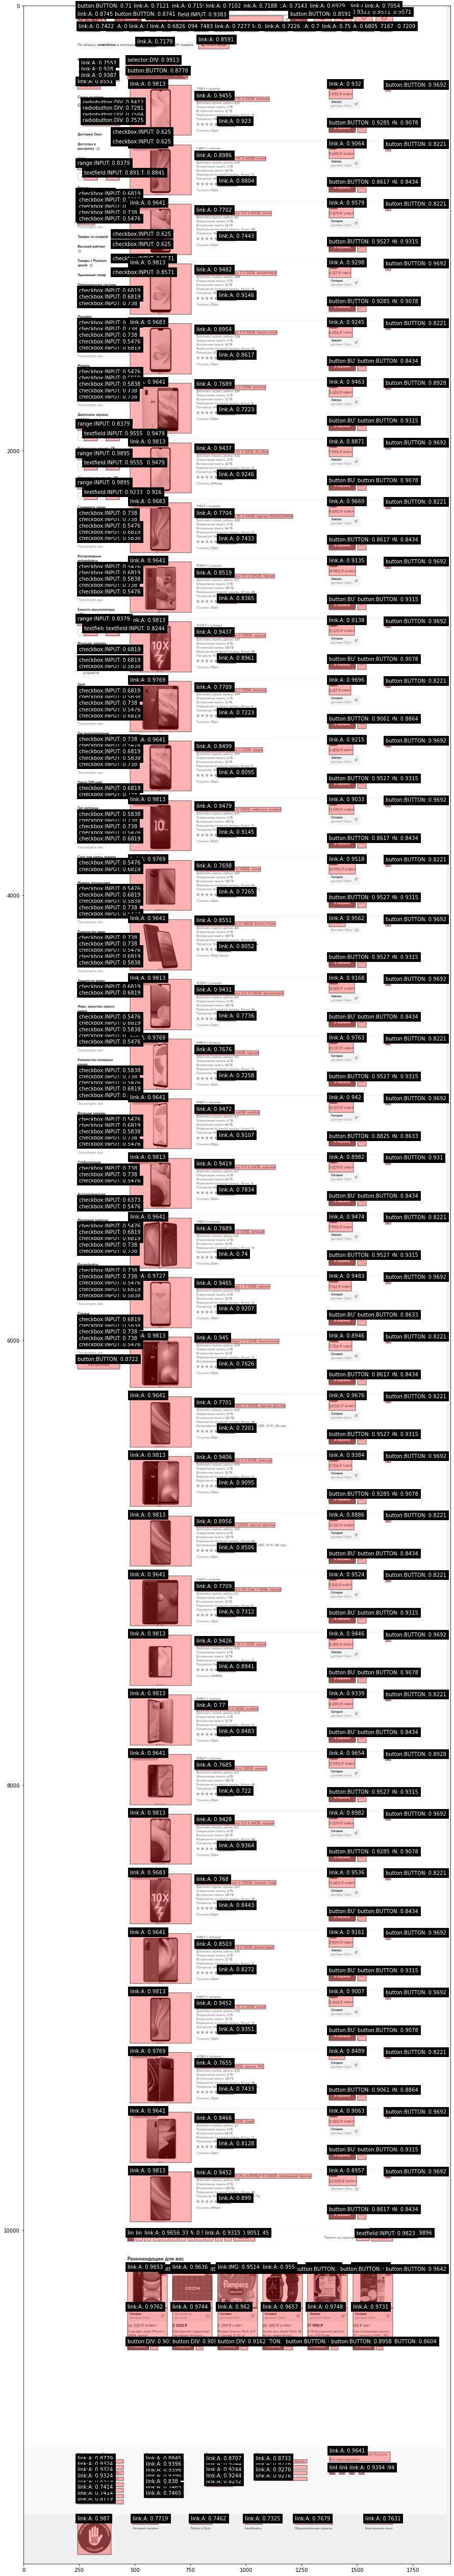

In [30]:
img = load_gray_image(f'dataset/images/{DATASET_NAME}.png')
img_height, img_width = img.shape
print(img_width, img_height)
plt.figure(figsize=(15, 500))
plt.imshow(img, cmap='gray')
axes = plt.gca()

for _, r in df[df.label_text != 'n/a'].iterrows():
    x, y, w, h = r.x, r.y, r.width, r.height  
    patch = patches.Rectangle((x, y), w, h, linewidth=2, alpha = .3, facecolor = 'red', edgecolor ='black')
    
    # print(r.tag_name, r.label_text, (x,y,w,h), r.element_id)
    
    axes.add_patch(patch)
    plt.text(x, y, 
             decoder_dict[r.label] + ':' + r.tag_name + ': ' +str(round(r.iou, 4)), # + ':' + str((x, y, w, h)),  ## + r.element_id, 
             fontsize = 10, 
             color = 'white', 
             backgroundcolor='black',
             alpha=1.)
